### Importing Packages and Data Preparation

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, make_scorer, brier_score_loss
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [20]:
path = 'C:/Users/habir/M4RAI/dataset/wdbc.data' # This path is hardcoded. Adjust it to your system if needed.
df = pd.read_csv(path)
df.columns = ['ID','Diagnosis','radius1','texture1','perimeter1',
              'area1','smoothness1','compactness1','concavity1','concave_points1',
             'symmetry1','fractal_dimension1','radius2','texture2','perimeter2',
              'area2','smoothness2','compactness2','concavity2','concave_points2',
             'symmetry2','fractal_dimension2','radius3','texture3','perimeter3',
              'area3','smoothness3','compactness3','concavity3','concave_points3',
             'symmetry3','fractal_dimension3']

X = df.drop(['Diagnosis', 'ID'],axis=1)
y = []
for entry in df['Diagnosis']:
    if entry == "B":
        y.append(0)
    elif entry == "M":
        y.append(1)
        
threshold = np.mean(y)
y_binary = (y > threshold).astype(int)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Setting up the Hyperparatmeters Set and the Classifer

The "Safety" class sets up hyperparameter grids for Logistic Regression, Random Forest, and Support Vector classifier, as well as setuping a GridSearch and RandomizedSearch cross-validation. There is also a function that calculates the best random state of a model depending on it's recall score, and a function that calculates a DICE coefficient.

In [3]:
class Safety():
    
    def __init__(self, model):
        if model:
            self.model = model
        else:
            self.model = ""
        
        if model == "logreg":
            self.param_grid = {
                    'C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'penalty': ['l2'],
                    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    'max_iter': [50, 100, 200, 500],
                    'class_weight': [None, 'balanced'],
                }
        elif model == "rf":
            self.param_grid = {
                    'n_estimators': [10, 20, 30],
                    'max_depth': [None, 10, 20, 30],
                    'min_samples_split': [3, 5, 7],
                    'min_samples_leaf': [1, 2, 4]
                }
        elif model == "svc":
            self.param_grid = {
                    'C': [1, 10, 100, 1000],
                    'kernel': ['linear', 'rbf'],
                    'gamma': [0.001, 0.0001]
                }
    
    def cross_val(self, search, model):
        if search == "grid":
            # Create the GridSearchCV object
            grid_search = GridSearchCV(model, self.param_grid, cv=5, scoring='recall', n_jobs=-1, error_score='raise')

            # Fit the GridSearchCV object to the data
            grid_search.fit(X_train_scaled, y_train)

            # Print the best hyperparameters found
            print("Best Hyperparameters:", grid_search.best_params_)

            # Get the best model
            best_model = grid_search.best_estimator_

            
        elif search == "random":
            # Inner Loop: Set up RandomizedSearchCV with inner cross-validation
            grid_search = RandomizedSearchCV(model, self.param_grid, cv=5, scoring='recall', 
                                       n_jobs=-1, error_score='raise')

            # Fit the RandomizedSearchCV object to the data
            grid_search.fit(X_train_scaled, y_train)

            # Print the best hyperparameters found
            print("Best Hyperparameters:", grid_search.best_params_)

            # Get the best model
            best_model = grid_search.best_estimator_

        # Make predictions on the test set using the best model
        y_pred_grid = best_model.predict(X_test_scaled)

        # Evaluate the model with the best hyperparameters using recall
        recall_grid = recall_score(y_test, y_pred_grid)
        conf_matrix_grid = confusion_matrix(y_test, y_pred_grid)
        classification_report_str_grid = classification_report(y_test, y_pred_grid)

        TP = int(conf_matrix_grid[0][0])
        FP = int(conf_matrix_grid[0][1])
        FN = int(conf_matrix_grid[1][0])
        
        dice_score = self.dice_coefficient(TP, FP, FN)
        print(f"\nDice Coefficient: {dice_score:.4f}")

        # Display the results
        print(f"\nBest Model Recall: {recall_grid:.4f}")
        print("\nConfusion Matrix (Best Model):")
        print(conf_matrix_grid)
        print("\nClassification Report (Best Model):")
        print(classification_report_str_grid)

        # Outer Loop: Perform nested cross-validation with outer cross-validation
        nested_cv_scores = cross_val_score(grid_search, X_train_scaled, y_train, cv=5, scoring='recall')

        # Calculate the mean and standard deviation of the nested cross-validation scores
        mean_nested_cv_score = np.mean(nested_cv_scores)
        std_nested_cv_score = np.std(nested_cv_scores)

        print("Mean Recall across Nested Cross-Validation:", mean_nested_cv_score)
        print("Standard Deviation of Recall across Nested Cross-Validation:", std_nested_cv_score)
        
    def random_state_recall(self, repetitions):

        best_rec = 0

        # Initialize a list to store accuracy scores
        recall = []

        # Repeat the train/test split 100 times with different random seeds
        for i in range(repetitions):
            random_state = i  # Use i as the random seed

            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

            # Standardize the features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            if self.model == "logreg":
                # Define the logistic regression model
                model = LogisticRegression(random_state=random_state)
                model.fit(X_train_scaled, y_train)
            elif self.model == "rf":
                model = RandomForestClassifier(random_state=random_state)
                model.fit(X_train_scaled, y_train)
            elif self.model == "svc":
                model = SVC(random_state=random_state)
                model.fit(X_train_scaled, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test_scaled)

            # Calculate recall score and append it to the list
            rec = recall_score(y_test, y_pred)
            recall.append(rec)

            if rec > best_rec:
                best_rec = rec
                best_state = random_state


        # Plot a boxplot of the accuracies
        plt.boxplot(recall)
        plt.title('Boxplot of Recalls across 100 Repetitions')
        plt.xticks([1],[self.model])
        plt.ylabel('Recall')
        plt.show()

        print(f"Best random state is {best_state} with recall of {best_rec}")
        
    def dice_coefficient(self, true_positives, false_positives, false_negatives):
        return (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)

## Model Robustness at The Prediction Stage: Estimating Epistemic Uncertainty using Bootstrapping Technique

Estimating epistemic uncertainty plays a crucial role in enhancing the safety of AI-based decision-making in several ways.
   
Here, we try to showcase how to use a bag of Logistic Regression to estimate the prediction uncertainty on our adapted cancer dataset. 

In [21]:
def uncertainty():
        # Define the base model without feature names
        base_model = LogisticRegression(random_state=1, max_iter=5000)

        # Define the BaggingClassifier with 100 base models
        model = BaggingClassifier(estimator=base_model, n_estimators=100, n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)  # Fit the BaggingClassifier without feature names

        y_pred = model.predict(X_test)
        recall = recall_score(y_test, y_pred)
        print(f"Recall of the Bagging Classifier Logistic Regression on the Test Set: {recall:.2f}")
        
        
        # Get the predictions from each base model in the ensemble
        predictions = np.array([estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_])

        # Calculate the 5th and 95th percentiles of the predictions
        lower_bound = np.percentile(predictions, 5, axis=0)
        upper_bound = np.percentile(predictions, 95, axis=0)
        median_predictions = np.median(predictions, axis=0)
        
        # Plot error bars for predictions
        indices = range(median_predictions.shape[0])
        plt.figure(figsize=[18,6])
        plt.errorbar(indices, median_predictions, yerr=[median_predictions - lower_bound, upper_bound - median_predictions], fmt='o',capsize=5)
        plt.scatter(indices, y_test[indices], marker='s', c='k')
        plt.title('Prediction Uncertainty for the First 100 Samples')
        plt.xlabel('Sample Index')
        plt.ylabel('Predicted Probability')
        plt.ylim(-0.1,1.1)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        
        threshold = 0.2
        idx = upper_bound - lower_bound < threshold

        accuracy = recall_score(y_test[idx], y_pred[idx])
        decisiveness = sum(idx)/idx.shape[0]

        print(f"The model can give us certain decisions about {decisiveness:.2f} of the test samples with the recall of: {recall:.2f}")

In [5]:
def calibration():
    # Train uncalibrated logreg on the training set
    model = LogisticRegression(random_state=1, max_iter=5000)
    model.fit(X_train, y_train)
    
    # Calibrate the SVC model on the validation set
    calibrated = CalibratedClassifierCV(estimator=model, cv='prefit', method='isotonic')
    calibrated.fit(X_val, y_val)
    
    # Predict probabilities on the test set
    probs = model.predict_proba(X_test)[:, 1]
    probs_calibrated = calibrated.predict_proba(X_test)[:, 1]

    # Compute calibration curve for SVC
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)

    # Compute calibration curve for calibrated SVC
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_test, probs_calibrated, n_bins=10)

    # Compute Brier scores
    brier_uncalibrated = brier_score_loss(y_test, probs)
    brier_calibrated = brier_score_loss(y_test, probs_calibrated)

    print("Brier Score (Uncalibrated):", brier_uncalibrated)
    print("Brier Score (Calibrated):", brier_calibrated)

    # Plot the calibration curve
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Uncalibrated')
    plt.plot(mean_predicted_value_calibrated, fraction_of_positives_calibrated, marker='x', label='Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

### Safety analysis on a Logistic Regression model

#### Grid Search

In [6]:
# Define the logistic regression model
logreg_model = LogisticRegression(random_state=1)

safety_logreg = Safety("logreg")

safety_logreg.cross_val("grid", logreg_model)

Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'}

Dice Coefficient: 0.9710

Best Model Recall: 0.9348

Confusion Matrix (Best Model):
[[67  1]
 [ 3 43]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        68
           1       0.98      0.93      0.96        46

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Mean Recall across Nested Cross-Validation: 0.9757575757575758
Standard Deviation of Recall across Nested Cross-Validation: 0.029690784761008195


#### Randomized Search

In [7]:
safety_logreg.cross_val("random", logreg_model)

Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'class_weight': 'balanced', 'C': 100}

Dice Coefficient: 0.9710

Best Model Recall: 0.9348

Confusion Matrix (Best Model):
[[67  1]
 [ 3 43]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        68
           1       0.98      0.93      0.96        46

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



C:\Users\habir\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mean Recall across Nested Cross-Validation: 0.9696969696969697
Standard Deviation of Recall across Nested Cross-Validation: 0.0271038542727247


#### Best random state

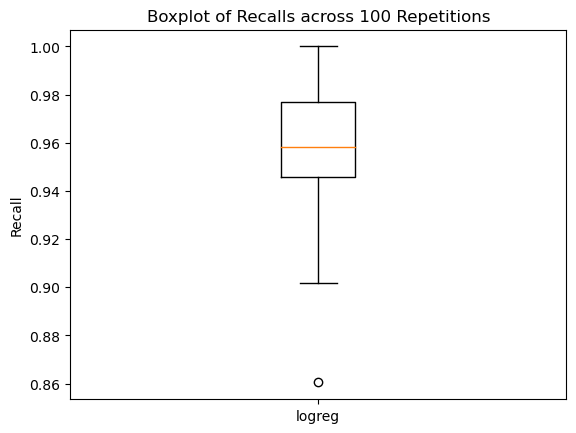

Best random state is 1 with recall of 1.0


In [8]:
safety_logreg.random_state_recall(100)

### Safety analysis on a Random Forest model

#### Grid Search

In [9]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=35)

safety_rf = Safety("rf")

safety_rf.cross_val("grid", rf)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 20}

Dice Coefficient: 0.9496

Best Model Recall: 0.8913

Confusion Matrix (Best Model):
[[66  2]
 [ 5 41]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        68
           1       0.95      0.89      0.92        46

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114

Mean Recall across Nested Cross-Validation: 0.9333333333333333
Standard Deviation of Recall across Nested Cross-Validation: 0.04848484848484848


#### Randomized Search

In [10]:
safety_rf.cross_val("random", rf)

Best Hyperparameters: {'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}

Dice Coefficient: 0.9353

Best Model Recall: 0.8696

Confusion Matrix (Best Model):
[[65  3]
 [ 6 40]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        68
           1       0.93      0.87      0.90        46

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.92       114
weighted avg       0.92      0.92      0.92       114

Mean Recall across Nested Cross-Validation: 0.9090909090909092
Standard Deviation of Recall across Nested Cross-Validation: 0.06639061303092922


#### Best random state

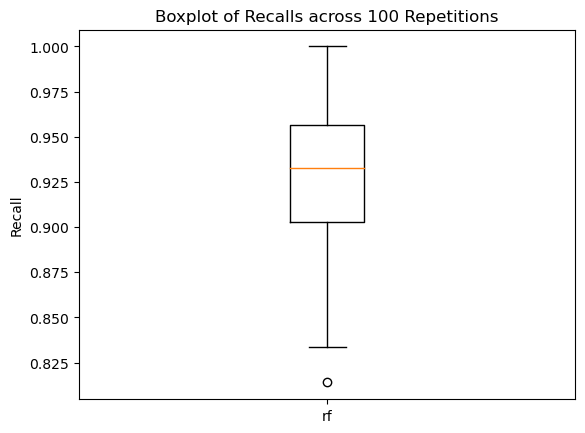

Best random state is 35 with recall of 1.0


In [11]:
safety_rf.random_state_recall(100)

### Safety analysis on a Support Vector Classifier model

#### Grid Search

In [12]:
svc = SVC(random_state=1)

safety_svc = Safety("svc")

safety_svc.cross_val("grid", svc)

Best Hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

Dice Coefficient: 0.9640

Best Model Recall: 0.9130

Confusion Matrix (Best Model):
[[67  1]
 [ 4 42]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        68
           1       0.98      0.91      0.94        46

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Mean Recall across Nested Cross-Validation: 0.9757575757575758
Standard Deviation of Recall across Nested Cross-Validation: 0.03533910239300183


#### Randomized Search

In [13]:
safety_svc.cross_val("random", svc)

Best Hyperparameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 10}

Dice Coefficient: 0.9640

Best Model Recall: 0.9130

Confusion Matrix (Best Model):
[[67  1]
 [ 4 42]]

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        68
           1       0.98      0.91      0.94        46

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Mean Recall across Nested Cross-Validation: 0.9757575757575758
Standard Deviation of Recall across Nested Cross-Validation: 0.03533910239300183


#### Best random state

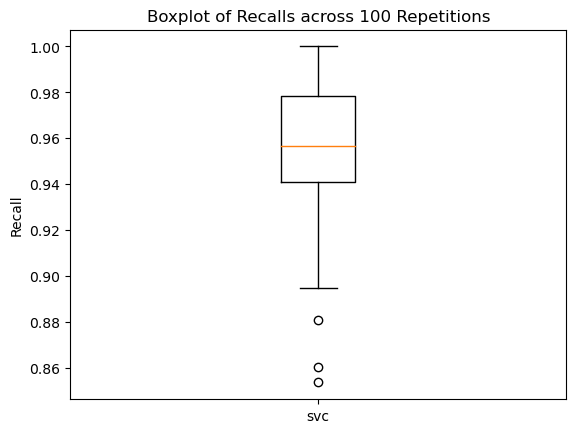

Best random state is 1 with recall of 1.0


In [14]:
safety_svc.random_state_recall(100)

## Model Robustness at The Prediction Stage: Model Calibration

Model calibration ensures that the model's predicted probabilities accurately reflect the true likelihood of the target event. Calibrated models yield more trustworthy and interpretable probabilities, aiding informed decision-making.

Brier Score (Uncalibrated): 0.024559452558017895
Brier Score (Calibrated): 0.0309268698734236


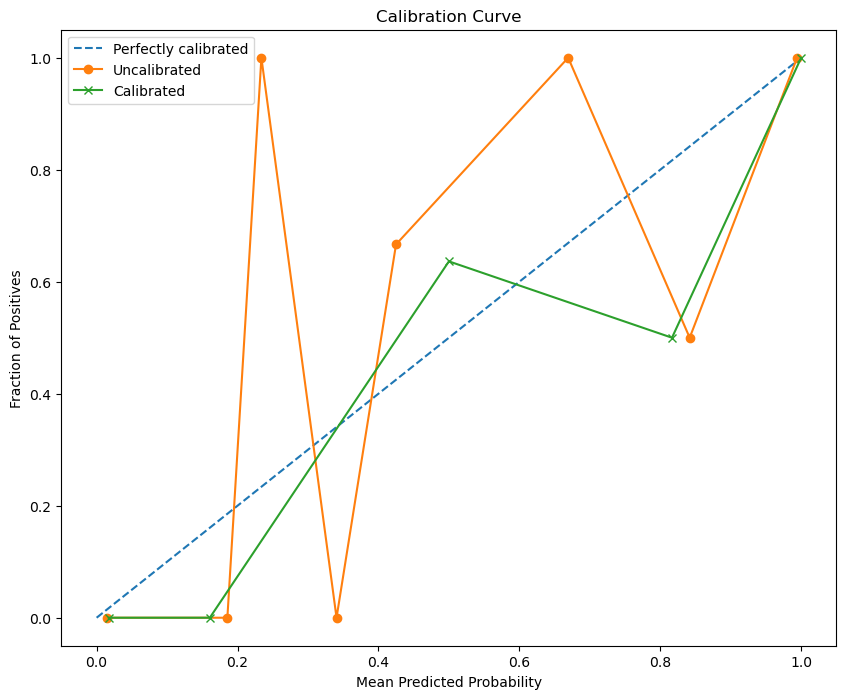

In [16]:
calibration()

### Epistemic Uncertainty analysis on a Logistic Regression

Recall of the Bagging Classifier Logistic Regression on the Test Set: 0.96


C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\habir\anaconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without featu

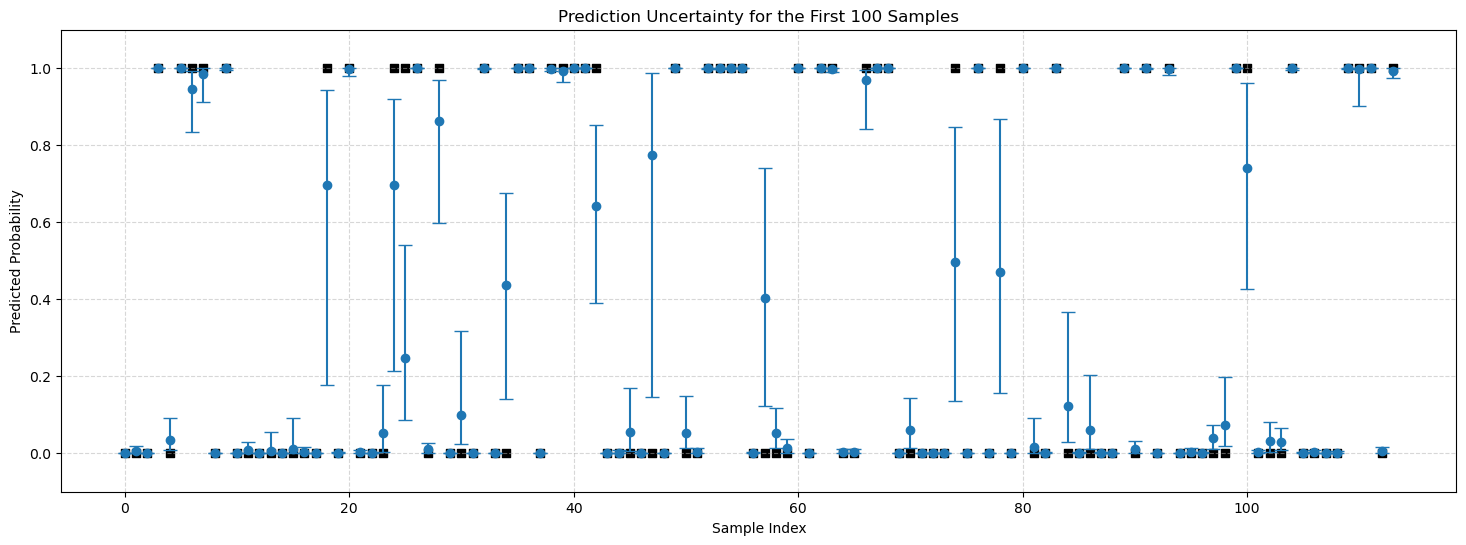

The model can give us certain decisions about 0.89 of the test samples with the recall of: 0.96


In [22]:
uncertainty()